# Recommendation Systems Assignment

### MIE451/1513 UofT

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget
from scipy.sparse.linalg import svds

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8ca457da7bd6884484ee713ca43eecd16c208d54fda5b75a1653e16b2fa95509
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [4]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [5]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [8]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [9]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [10]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector
                userVector = train_matrix[user, :]
                
                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()]
                
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [11]:
popularity_recsys = BaseLineRecSys('popularity')

In [12]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [13]:
x = popularity_recsys.getModel()

In [14]:
np.all(x<=1)

True

In [15]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:47, 2087.16it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [17]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [18]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [19]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [20]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:46, 2141.23it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [21]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean'))
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='manhattan'))
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            # IxU
            train_matrix = train_matrix.T 
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            
            # IxU: IxI mul IxU
            normalizer = np.matmul(ii_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            predictionMatrix = predictionMatrix.T
            self.__model = predictionMatrix # UxI
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [22]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [24]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

**I think cosine similarity would work better. since cosine similarity measure the cosine of angle between two vector and does not affect by the size of vector. And euclidean distance calculate outliers with small distance and this will lead to high similarity, which is not desirable.**

### (b)

**I used Manhattan distance in something else. Manhattan distance is less sensitive with outliers than eclidean distance. since manhattan distance calculate the sum of distances in each dimension, it is less easier to have super huge distance when outliers exist. Like the example in part (a), manhattan distance calculate 
Sum of sides of right triangle while euclidean distance calculate the hypotenuse of a right triangle. And obviously, Sum of sides of right triangle is greater than hypotenuse of a right triangle. However, manhattan similarity is smaller than euclidean similarity, which indicates manhattan similarity will obtian less similarity when calculate with outliers.**

## Q3

### (a)

In [25]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [26]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [27]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [28]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:08, 1465.49it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [30]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [00:48, 2071.56it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [31]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [32]:
# How to use CrossValidation Class?

In [33]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys,
                       user_cosine_recsys]

In [34]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision

cv_rmse = CrossValidation('RMSE')

In [35]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
result = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3168.12it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3201.11it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3180.39it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3147.28it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3154.58it/s]


Processing algorithm user-cosine


20000it [00:06, 3172.39it/s]
20000it [00:06, 3184.14it/s]
20000it [00:06, 3219.55it/s]
20000it [00:06, 3200.32it/s]
20000it [00:06, 3175.89it/s]


In [36]:
result

{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

In [37]:
Q3_df = pd.DataFrame.from_dict(data=result, orient='index', columns=[['fold_scores', 'mean', 'ci_low', 'ci_high']])
Q3_df

,fold_scores,mean,ci_low,ci_high
item-cosine,"[1.0377631264364244, 1.0207280585350078, 1.010...",1.020083,1.006824,1.033342
user-cosine,"[1.026449013124381, 1.0214387664779507, 1.0132...",1.017354,1.009013,1.025695


In [38]:
tm = dataPreprocessor(rating_df, num_users, num_items)
tm1 = np.zeros(tm.shape)
tm1[tm.nonzero()] = 1
tm1.sum()/tm.shape[0] # average number of ratings per user


106.04453870625663

In [39]:
tm1.sum()/tm.shape[1] # average number of ratings per item

59.45303210463734

**user-cosine method have a slightly smaller RMSE than item-cosine method, which means user-cosine method performs better than item-cosine method in this case. I found that average number of ratings per user is larger than average number of ratings per item. Thus, in average, missing ratings for each item is much larger than missing ratings for each user, which means item-item based has more uncertainty. Thus, CI of item-cosine is larger than CI of user-cosine.**

## Q4

### (a)

In [40]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = np.random.randn(num_item, self.num_feat) * np.sqrt(0.1)  # item M x D 
        self.w_User = np.random.randn(num_user, self.num_feat) * np.sqrt(0.1)  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########

                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis=1) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis=1) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out =  np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis=1)#size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()

          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [43]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 22, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

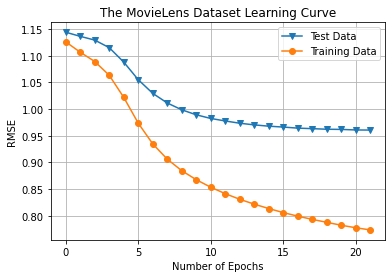

In [42]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [44]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys,
                       average_user_rating_recsys,
                       item_cosine_recsys,
                       user_cosine_recsys,
                       pmf]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
cv_rmse = CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_rprecision = CrossValidation('RPrecision')

# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
result_rmse = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)
result_patk = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
result_rprecision = cv_rprecision.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3182.49it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3156.36it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3196.86it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3114.58it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3177.79it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3181.04it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3141.68it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3134.40it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3130.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3189.18it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3194.38it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3201.43it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3199.77it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3180.94it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3188.04it/s]


Processing algorithm user-cosine


20000it [00:06, 3187.00it/s]
20000it [00:06, 3198.17it/s]
20000it [00:06, 3186.70it/s]
20000it [00:06, 3184.61it/s]
20000it [00:06, 3197.26it/s]


Processing algorithm PMF


20000it [00:09, 2134.31it/s]
20000it [00:09, 2112.88it/s]
20000it [00:09, 2130.30it/s]
20000it [00:09, 2134.94it/s]
20000it [00:09, 2123.81it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3216.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3184.00it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3197.69it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3241.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3187.10it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3207.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3197.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3159.39it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3140.60it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3188.32it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3216.20it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3158.60it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3153.15it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3186.77it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3191.63it/s]


Processing algorithm user-cosine


20000it [00:06, 3180.65it/s]
20000it [00:06, 3168.71it/s]
20000it [00:06, 3193.54it/s]
20000it [00:06, 3206.51it/s]
20000it [00:06, 3181.89it/s]


Processing algorithm PMF


20000it [00:09, 2132.06it/s]
20000it [00:09, 2122.99it/s]
20000it [00:09, 2138.30it/s]
20000it [00:09, 2165.77it/s]
20000it [00:09, 2132.88it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3215.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3206.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3180.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3234.63it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3213.69it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3088.01it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3118.23it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3188.57it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3173.65it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3168.22it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3200.64it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3191.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3176.42it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3207.75it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3150.32it/s]


Processing algorithm user-cosine


20000it [00:06, 3182.80it/s]
20000it [00:06, 3162.60it/s]
20000it [00:06, 3191.90it/s]
20000it [00:06, 3178.62it/s]
20000it [00:06, 3187.97it/s]


Processing algorithm PMF


20000it [00:09, 2169.81it/s]
20000it [00:09, 2145.35it/s]
20000it [00:09, 2126.28it/s]
20000it [00:09, 2174.95it/s]
20000it [00:09, 2113.18it/s]


In [45]:
Q5_df_rmse = pd.DataFrame.from_dict(data=result_rmse, orient='index', columns=[['fold_scores', 'mean', 'ci_low', 'ci_high']])
Q5_df_rmse

,fold_scores,mean,ci_low,ci_high
popularity,"[3.177941281084362, 3.1750480150769977, 3.1474...",3.159093,3.139293,3.178893
useraverage,"[1.0629951276561334, 1.0467467492319966, 1.032...",1.043718,1.028930,1.058505
item-cosine,"[1.0377631264364244, 1.0207280585350078, 1.010...",1.020083,1.006824,1.033342
user-cosine,"[1.026449013124381, 1.0214387664779507, 1.0132...",1.017354,1.009013,1.025695
PMF,"[0.981543438552932, 0.9695338693027042, 0.9547...",0.962772,0.946877,0.978668


In [46]:
Q5_df_patk = pd.DataFrame.from_dict(data=result_patk, orient='index', columns=[['fold_scores', 'mean', 'ci_low', 'ci_high']])
Q5_df_patk

,fold_scores,mean,ci_low,ci_high
popularity,"[0.36924708377518656, 0.4965005302226948, 0.61...",0.550583,0.405441,0.695725
useraverage,"[0.30604453870625714, 0.4305408271474029, 0.53...",0.473637,0.341999,0.605275
item-cosine,"[0.34316012725344736, 0.483563096500532, 0.602...",0.532216,0.383701,0.680732
user-cosine,"[0.37179215270413657, 0.503923647932133, 0.621...",0.555843,0.409598,0.702088
PMF,"[0.36755037115588646, 0.4958642629904574, 0.62...",0.549353,0.404433,0.694273


In [47]:
Q5_df_rprecision = pd.DataFrame.from_dict(data=result_rprecision, orient='index', columns=[['fold_scores', 'mean', 'ci_low', 'ci_high']])
Q5_df_rprecision

,fold_scores,mean,ci_low,ci_high
popularity,"[0.7177873723889607, 0.7070154178036713, 0.712...",0.717666,0.706824,0.728509
useraverage,"[0.6403680886295169, 0.6452698039088018, 0.641...",0.645730,0.639631,0.651830
item-cosine,"[0.6999034077107555, 0.7051212779090774, 0.713...",0.708014,0.700692,0.715336
user-cosine,"[0.7177834541075783, 0.7127674206396806, 0.715...",0.721019,0.709995,0.732042
PMF,"[0.7113524057119219, 0.7017052398144908, 0.709...",0.706901,0.700840,0.712961


### (b)

**I found a rmse of popularity is way higher than rmse of other algorithm, which means popularity cannot be evaluated with rmse. In popularity, popularity is calculate by num of rating >= 4 divided by num of rating, which means popularity is in range of (0,1). Thus, it does not make sense to use popularity to calculate distance(rmse) with ratings.**

###(c)

**Best algorithm for RMSE: PMF, since PMF use Gradient descent to minimize the distance between predicted rating and actual rating.
Best algorithm for p@K: user-cosine, since cosine similarity performs well on calculating the similarity of two vectors and average number of ratings per user is larger than average number of ratings per item. Thus, user-cosine performs better than item-cosine.
Best algorithm for R-Precision: user-cosine, since cosine similarity performs well on calculating the similarity of two vectors and average number of ratings per user is larger than average number of ratings per item. Thus, user-cosine performs better than item-cosine.**


###(d)

**1. I think good performance on RMSE deos not implies good performance on ranking metric, since if RMSE performs well(RMSE is very small), then it means that predicted ratings are quite match to actual ratings, but it cannot gurantee predicted ratings are quite match to actual ratings in topk ranking.  2. Good performances on ranking metric does not impies good performances on RMSE if k is small, since good performance on top k cannot gurantee good performance on out of topk.**

## Q6

### (a)

In [48]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [49]:
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
ii_similarity = SimBasedRecSys.cosine(train_matrix.T)
ii_similarity

array([[1.        , 0.40238218, 0.33024479, ..., 0.        , 0.04718307,
        0.04718307],
       [0.40238218, 1.        , 0.27306918, ..., 0.        , 0.07829936,
        0.07829936],
       [0.33024479, 0.27306918, 1.        , ..., 0.        , 0.        ,
        0.09687505],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.04718307, 0.07829936, 0.09687505, ..., 0.        , 0.        ,
        1.        ]])

In [50]:
num=5
np.argsort(ii_similarity[666])[::-1][1:num+1]
moviesDF.movieTitle.to_numpy()[np.argsort(ii_similarity[666])[::-1][1:num+1]]

array(['Fire on the Mountain (1996)',
       'Police Story 4: Project S (Chao ji ji hua) (1993)',
       'NeverEnding Story III, The (1994)', 'Blood Beach (1981)',
       'Amityville II: The Possession (1982)'], dtype=object)

In [51]:
movies = [996, 530, 818]
for mov in movies:    
    movie_index = np.argsort(ii_similarity[mov])[::-1][1:num+1]
    movie_names = moviesDF.movieTitle.to_numpy()[movie_index]
    print('Choosing movie name: {}, the top 5 most similar movies are {}.'.format(moviesDF.movieTitle.to_numpy()[mov], movie_names))

Choosing movie name: Stuart Saves His Family (1995), the top 5 most similar movies are ['Fear of a Black Hat (1993)' 'War, The (1994)' 'Angus (1995)'
 'Small Faces (1995)' 'Getting Away With Murder (1996)'].
Choosing movie name: Shine (1996), the top 5 most similar movies are ['Quiz Show (1994)' 'Pulp Fiction (1994)' 'Piano, The (1993)'
 'Sling Blade (1996)' 'Shawshank Redemption, The (1994)'].
Choosing movie name: Eddie (1996), the top 5 most similar movies are ['Associate, The (1996)' 'Bed of Roses (1996)' 'Race the Sun (1996)'
 'Phenomenon (1996)' 'Father of the Bride Part II (1995)'].


### (b)

**I cannot justify all similarity. Some recommend movie is similar to the movie I select.For example, I choose Stuart Saves His Family (1995), which is a comedy moive, and recommended Fear of a Black Hat (1993), which is also a comedy. But also recommend War, The (1994), which is a war movie rather than comedy. The reason may be num of rating for some movie is not enough, which means it contains high uncertainty.**

## Q7

### (a)

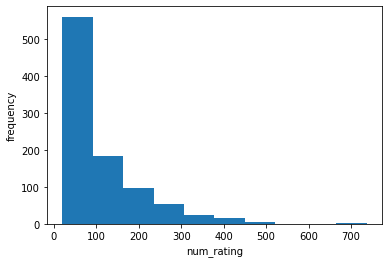

In [52]:
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
# Initialize the predicted rating matrix with zeros
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1
num_rating = np.sum(temp_matrix, axis=1)
plt.hist(num_rating)
plt.xlabel("num_rating")
plt.ylabel('frequency')
plt.show()


**Look insight more detail from 0 to 100.**

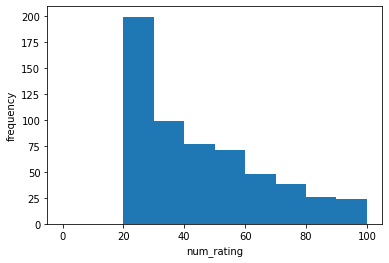

In [53]:
plt.hist(num_rating, range=(0,100))
plt.xlabel("num_rating")
plt.ylabel('frequency')
plt.show()

**I would choose 60 as threshold.**

In [54]:
up_case = rating_df.groupby('userID')['rating'].count() >= 60
up_case = up_case.to_frame(name='boolen')
up_index = up_case[up_case.boolen == True].index
rating_df[rating_df.userID.isin(up_index)]

,userID,itemID,rating,timestamp
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
5,298,474,4,884182806
6,115,265,2,881171488
...,...,...,...,...
99994,378,78,3,880056976
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795


In [55]:
lower_case = rating_df.groupby('userID')['rating'].count() < 60
lower_case = lower_case.to_frame(name='boolen')
lower_index = lower_case[lower_case.boolen == True].index
rating_df[rating_df.userID.isin(lower_index)]

,userID,itemID,rating,timestamp
0,196,242,3,881250949
4,166,346,1,886397596
30,50,246,3,877052329
32,225,193,4,879539727
35,157,274,4,886890835
...,...,...,...,...
99948,780,50,5,891363685
99978,113,975,5,875936424
99981,750,323,3,879445877
99983,646,750,3,888528902


In [56]:
data_types = ['u{0}.base','u{0}.test']
dfff = getData(MOVIELENS_DIR, data_types[0].format(1)).set_index('userID')
dfff

,itemID,rating,timestamp
userID,,,
1,1,5,874965758
1,2,3,876893171
1,3,4,878542960
1,4,3,876893119
1,5,3,889751712
...,...,...,...
943,1067,2,875501756
943,1074,4,888640250
943,1188,3,888640250


In [57]:
class CrossValidation_with_threshold(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR, threshold='up'):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(threshold, MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(threshold, data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            if threshold == 'up':   
                train_set = train_set[train_set.userID.isin(up_index)]
                test_set = test_set[test_set.userID.isin(up_index)] 
            else:
                train_set = train_set[train_set.userID.isin(lower_index)]
                test_set = test_set[test_set.userID.isin(lower_index)]
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results      

In [58]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys,
                       user_cosine_recsys]

cv_rmse = CrossValidation_with_threshold('RMSE', threshold = 'up')
Q7_up = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)
pd.DataFrame.from_dict(data=Q7_up, orient='index', columns=[['fold_scores', 'mean', 'ci_low', 'ci_high']])

Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
17110it [00:05, 3154.11it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
17039it [00:05, 3150.81it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
16842it [00:05, 3194.09it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
16805it [00:05, 3146.18it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
16800it [00:05, 3108.43it/s]


Processing algorithm user-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
17110it [00:05, 3104.83it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
17039it [00:05, 3139.63it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
16842it [00:05, 3173.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
16805it [00:05, 3126.92it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
16800it [00:05, 3178.93it/s]


,fold_scores,mean,ci_low,ci_high
item-cosine,"[1.0414573747283948, 1.0211881672744636, 1.007...",1.019354,1.002367,1.036342
user-cosine,"[1.0222508500700602, 1.0129894528002998, 1.007...",1.011354,1.001380,1.021327


In [59]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys,
                       user_cosine_recsys]

cv_rmse = CrossValidation_with_threshold('RMSE', threshold = 'down')
Q7_down = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)
pd.DataFrame.from_dict(data=Q7_down, orient='index', columns=[['fold_scores', 'mean', 'ci_low', 'ci_high']])

Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
2890it [00:00, 3410.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
2961it [00:00, 3314.68it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
3158it [00:00, 3358.31it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
3195it [00:00, 3332.99it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
3200it [00:00, 3374.63it/s]


Processing algorithm user-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
2890it [00:00, 3308.90it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
2961it [00:00, 3328.52it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
3158it [00:00, 3271.70it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
3195it [00:00, 3224.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
3200it [00:00, 3283.55it/s]


,fold_scores,mean,ci_low,ci_high
item-cosine,"[1.1692417179982133, 1.154541859294865, 1.1518...",1.153364,1.134977,1.171752
user-cosine,"[1.0856180547940522, 1.111579600416544, 1.0972...",1.100031,1.087517,1.112546


**For users with rating num over or equal to 60, mean of RMSE for both user-cosine and item-cosine less than those of users with rating num under 60. And also, for users with rating num over or equal to 60, CIs of RMSE for both user-cosine and item-cosine more narrow than those of users with rating num under 60. The reason may be that as users with high num of rating contians less uncertainty. Besides that, user-cosine performs better than item-cosine, the reason may be that average number of ratings per user is larger than average number of ratings per item. Thus, user-user contain more information that item-item.**

## Q8

**For SVD part, I modified the code from: https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65**

In [60]:
class CompetitionRecSys(object):
    """
    You can define new methods if you need. Don't use global variables in the class. 
    """
    def __init__(self):
        """
        Initialization of the class
        1. Make sure to fill out self.pred_column_name, the name you give  to your competition method
        
        """
        ########## your code goes here ###########

        
        self.pred_column_name = 'RPrecision'
        # self.pred_column_name = 'RPrecision'
        ###########         end         ###########

    def predict_all(self, train_vec, num_user, num_item):
        """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            num_user: scalar. number of users
            num_item: scalar. number of items
        OUTPUT:
            no return... 
        
        NOTES:
            This function is where you train your model
        """
                
        ########## your code goes here ###########
        train_df = train_vec
        train_matrix = dataPreprocessor(train_df, num_user, num_item)
        # temp_matrix = np.zeros(train_matrix.shape)
        # temp_matrix[train_matrix.nonzero()] = 1
        df_matrix = train_matrix
        df = pd.DataFrame(df_matrix)
        df[df==0] = np.nan
        itemaverage = np.mean(df, axis=0)
        itemaverage.replace(np.nan,np.mean(itemaverage),inplace=True)
        itemaverage = itemaverage.to_numpy()
        # itemaverage = pd.DataFrame(itemaverage)
        # itemaverage.replace(np.nan,np.mean(itemaverage, axis=0),inplace=True)
        # print(itemaverage.isnull().sum())
        # itemaverage = itemaverage.to_numpy()
        itemstd = np.std(df, axis=0).to_numpy()
        # print(np.mean(df, axis=1).isnull().sum())
        # df.replace(np.nan,np.mean(df, axis=0),inplace=True)
        # df.replace(np.nan,np.mean(df, axis=1),inplace=True)
        # print(df.isnull().sum())
        df_matrix = df.to_numpy()
        
        # # columns = np.sum(train_matrix, axis=0)
        # #     #print(columns.shape)
        # # train_matrix[:, columns==0] = train_matrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
        # df_matrix = (df_matrix - itemaverage.reshape(1,-1))/itemstd.reshape(1,-1)
        # # train_matrix = np.where(train_matrix==0, np.nan, train_matrix)
        
        df_matrix = df_matrix - itemaverage.reshape(1,-1)

        
        U, s, V = svds(df_matrix, k = 20)
    

        s=np.diag(s)

        UsV = np.dot(np.dot(U, s), V)
        # UsV = UsV + mean_mat.reshape(-1,1)
        # UsV = UsV*itemstd.reshape(1,-1) + itemaverage.reshape(1,-1)
        UsV = UsV + itemaverage.reshape(1,-1)
        df_matrix = UsV
        # df_matrix = pd.DataFrame(df_matrix)
        # df_matrix.replace(np.nan,0,inplace=True)
        # df_matrix.replace(0,np.mean(df_matrix, axis=0),inplace=True)
        # df_matrix[df_matrix==0] = 1e-5
        # print(df_matrix.isnull().sum())
        # itemaverage = pd.DataFrame(itemaverage)
        # print(itemaverage.isnull().sum())
        # df_matrix = df_matrix.to_numpy()

        # temp_matrix = np.zeros(df_matrix.shape)
        # temp_matrix[df_matrix.nonzero()] = 1
        # useraverage = np.sum(df_matrix, axis=1)/np.sum(df_matrix, axis=1)
        # columns = np.sum(df_matrix, axis=0)
        # #print(columns.shape)
        # df_matrix[:, columns==0] = df_matrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        # df_matrix = pd.DataFrame(df_matrix)
        
        # print(df_matrix.isnull().sum())
        # df_matrix = df_matrix.to_numpy()

        # useraverage = np.sum(UsV, axis=1)/np.sum(temp_matrix, axis=1)
        # predictionMatrix = UsV
        # columns = np.sum(predictionMatrix, axis=0)
        # print(columns.shape)
        # predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        # self.__model = df_matrix
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
        
        # UxI: UxU mul UxI
        normalizer = np.matmul(uu_similarity, temp_matrix)
        #print(normalizer)
        normalizer[normalizer == 0] = 1e-5
        #what's the dimension of np.matmul(uu_similarity, trainSet)
        # print(uu_similarity.shape)
        # print(train_matrix.shape)
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
        #predictionMatrix[temp_matrix.nonzero()] = 0
        #Cold start
        # if no one has rated this item before, use user average  
        useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
        columns = np.sum(predictionMatrix, axis=0)
        #print(columns.shape)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        p1 = predictionMatrix
        # self.__model = (0.95*predictionMatrix + 0.05*df_matrix)
        ###########         end         ###########
        
        ########### your code goes here ###########
        # IxU
        train_matrix = train_matrix.T 
        # Initialize the predicted rating matrix with zeros
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
        
        # IxU: IxI mul IxU
        normalizer = np.matmul(ii_similarity, temp_matrix)
        #print(normalizer)
        normalizer[normalizer == 0] = 1e-5
        #what's the dimension of np.matmul(uu_similarity, trainSet)
        
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
        #predictionMatrix[temp_matrix.nonzero()] = 0
        #Cold start
        # if no one has rated this item before, use user average  
        itemaverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
        columns = np.sum(predictionMatrix, axis=0)
        #print(columns.shape)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
        predictionMatrix = predictionMatrix.T
        self.__model = 0.7*predictionMatrix + 0.2*p1 +0.1*df_matrix # UxI
            ###########         end         ###########
        # else:
        #     print('No other option available')
        ###########         end         ###########

        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]

            NOTES:
            This function is where your model makes prediction 
            Please fill out: prediction.loc[index, self.pred_column_name] = None                            
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            ########### your code goes here ###########
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
            ###########         end         ###########

        return prediction
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        ########### your code goes here ###########
        try:
            self.model = None
        except:
            print("You do not have model..")
        ##########         end         ###########


In [61]:
competition = CompetitionRecSys()
algorithm_instances = [competition]
cv_rp = CrossValidation('RPrecision')
rp = cv_rp.run(algorithm_instances, num_users, num_items)

Processing algorithm RPrecision


/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1883: RuntimeWarning: invalid value encountered in greater
  above_cutoff = (eigvals > cutoff)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3147.58it/s]
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1883: RuntimeWarning: invalid value encountered in greater
  above_cutoff = (eigvals > cutoff)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3163.26it/s]
/usr/local/lib/python3.6/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1883: RuntimeWarning: invalid value encountered in greater
  above_cutoff = (eigvals > cutoff)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide
20000it [00:06, 3161.03it/s]
/usr/local/li

In [62]:
rp

{'RPrecision': [[0.7245525433072737,
   0.7251988370275796,
   0.732757230565367,
   0.7332966303052941,
   0.7454953275839973],
  0.7322601137579025,
  0.7217652862637586,
  0.7427549412520463]}

**I use 3 methods: SVD,user-cosine, item-cosine. After get prediction matrix for each of 3 methods. I use ensemble methods and tune different weight on each of 3 methods, and then sum them together. Finally, R-Precision is 0.7322601137579025.**

# Validation

In [63]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [64]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [65]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [66]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [67]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [68]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [69]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [70]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [71]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [72]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [73]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [74]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [75]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [76]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [77]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [78]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [79]:
validatePMFRecSys(validation_df=validation_df)